In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('./data/sav_2013_2017.csv')
data.head()

,date,enem_days,hits,near_av
0,2013-07-31 00:00:00,87.0,0.0,0.0
1,2013-07-31 01:00:00,86.0,0.0,0.0
2,2013-07-31 02:00:00,86.0,0.0,0.0
3,2013-07-31 03:00:00,86.0,0.0,0.0
4,2013-07-31 04:00:00,86.0,0.0,0.0


In [3]:
traffic = data[['enem_days', 'near_av', 'hits']]

In [4]:
traffic.head()

,enem_days,near_av,hits
0,87.0,0.0,0.0
1,86.0,0.0,0.0
2,86.0,0.0,0.0
3,86.0,0.0,0.0
4,86.0,0.0,0.0


In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
hit_scaler = MinMaxScaler(feature_range=(0,1))

length = len(traffic)

traffic.values[:,0] = scaler.fit_transform(np.matrix(traffic.enem_days).T).reshape((length))
traffic.values[:,1] = scaler.fit_transform(np.matrix(traffic.near_av).T).reshape((length))

traffic.values[:,2] = hit_scaler.fit_transform(np.matrix(traffic.hits).T).reshape((length))

In [7]:
traffic.hits.mean(), traffic.hits.std()

(0.019976910036883327, 0.04429679657417148)

In [8]:
window_size = 2

In [9]:
def get_rolling_window(data, window_size):
    x, y, val = [], [], len(data) - window_size
    for z in range(val-1):
        x.append(data.values[z:(z + window_size)])
        y.append(data.values[z + window_size,-1:])
    return np.array(x), np.array(y)

In [10]:
split_factor = 0.8
split_row = int(len(traffic) * split_factor)
split_row

31008

In [11]:
train_data, test_data = traffic[:split_row], traffic[split_row:]
X_train, y_train = get_rolling_window(train_data, window_size)
X_test, y_test = get_rolling_window(test_data, window_size)

len(X_train), len(X_test)

(31004, 7748)

In [12]:
print(y_train[18856][0])
print(X_train[18856:18858])

0.185649202733
[[[ 0.15425532  0.          0.07744875]
  [ 0.15425532  0.          0.07403189]
  [ 0.15425532  0.          0.10022779]]

 [[ 0.15425532  0.          0.07403189]
  [ 0.15425532  0.          0.10022779]
  [ 0.15425532  0.          0.1856492 ]]]


In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN

Using TensorFlow backend.


In [14]:
model = Sequential()
batch_size = 1
model.add(SimpleRNN(3, batch_input_shape=(batch_size, window_size, 3), stateful=True, return_sequences=True))
model.add(LSTM(3, batch_input_shape=(batch_size, window_size, 3), stateful=True, return_sequences=True))
model.add(LSTM(5,batch_input_shape=(batch_size, window_size, 3), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)

Epoch 1/10
207s - loss: 2.3697e-04
Epoch 2/10
202s - loss: 1.0182e-04
Epoch 3/10
200s - loss: 1.0148e-04
Epoch 4/10
187s - loss: 9.7135e-05
Epoch 5/10
192s - loss: 9.3271e-05
Epoch 6/10
187s - loss: 9.1531e-05
Epoch 7/10
187s - loss: 9.0085e-05
Epoch 8/10
189s - loss: 8.9087e-05
Epoch 9/10
189s - loss: 8.8866e-05
Epoch 10/10
188s - loss: 8.8438e-05


In [16]:
def inverse_transform(pred):    
    return hit_scaler.inverse_transform(pred)

In [17]:
pred_x_train = model.predict(X_train, batch_size)
pred_train = inverse_transform(pred_x_train)
pred_train[pred_train < 0] = 0.

In [18]:
y_train = np.float_(y_train)
y_train_inv = inverse_transform(y_train)

In [19]:
pred_x_test = model.predict(X_test, batch_size)
pred_test = inverse_transform(pred_x_test)
pred_test[pred_test < 0] = 0.

In [20]:
y_test = np.float_(y_test)
y_test_inv = inverse_transform(y_test)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [22]:
def get_mse(real, pred):
    return math.sqrt(mean_squared_error(real, pred))

def get_mae(real, pred):
    return mean_absolute_error(real, pred)

In [23]:
train_mse = get_mse(y_train_inv, pred_train)
test_mse = get_mse(y_test_inv, pred_test)

print('Train Score: %.2f RMSE' % (train_mse))
print('Test Score: %.2f RMSE' % (test_mse))

Train Score: 23.77 RMSE
Test Score: 61.48 RMSE


In [24]:
train_mae = get_mae(y_train_inv, pred_train)
test_mae = get_mae(y_test_inv, pred_test)

print('Train Score: %.2f MAE' % (train_mae))
print('Test Score: %.2f MAE' % (test_mae))

Train Score: 13.66 MAE
Test Score: 30.69 MAE


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [26]:
line_test_pred = np.reshape(pred_test, pred_test.shape[0])
line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])

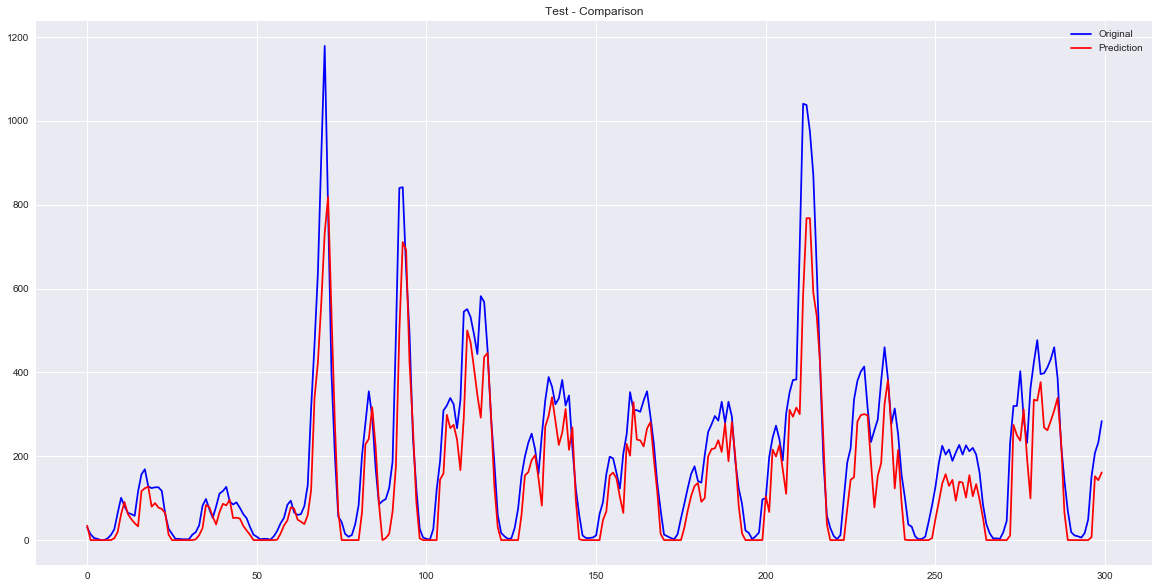

In [27]:
plt.figure(figsize=(20,10))
plt.plot(line_test_real[1100:1400], color='blue',label='Original')
plt.plot(line_test_pred[1100:1400], color='red',label='Prediction')
plt.legend(loc='best')
plt.title('Test - Comparison')
plt.show()

In [28]:
line_train_pred = np.reshape(pred_train, pred_train.shape[0])
line_train_real = np.reshape(y_train_inv, y_train_inv.shape[0])

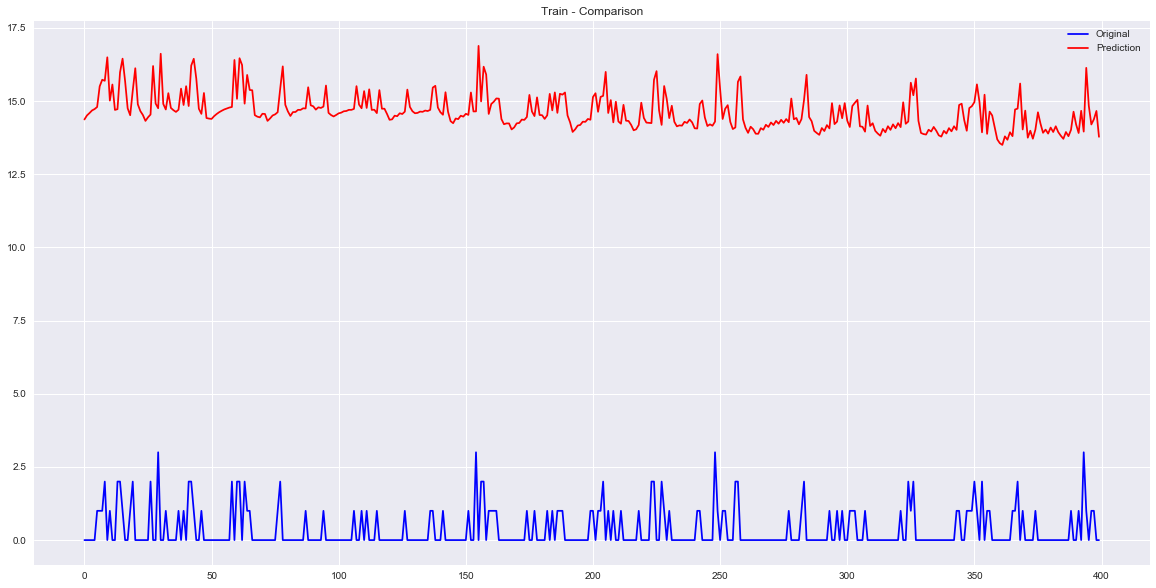

In [29]:
plt.figure(figsize=(20,10))
plt.plot(line_train_real[3000:3400], color='blue',label='Original')
plt.plot(line_train_pred[3000:3400], color='red',label='Prediction')
plt.legend(loc='best')
plt.title('Train - Comparison')
plt.show()